# Graph Mamba

### Loading the Cora dataset using PyTorch Geometric

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_cluster import random_walk
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ipywidgets import interact, IntSlider

device = torch.device("mps")

ds = Planetoid(root="./data", name="Cora")
data = ds[0]
data = data.to(device)
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

## Tokenization

### Neighborhood Sampling

In [3]:
edge_index = data.edge_index.cpu()
n = data.num_nodes

max_walk_length = 3
num_of_walks = 4

tokens = {v: {} for v in range(n)}

for node in range(n):
    for walk_length in range(1, max_walk_length + 1):
        induced_graph = set()

        for i in range(1, num_of_walks + 1):
            walk = random_walk(edge_index[0], edge_index[1], torch.tensor([node]), walk_length=walk_length)[0]
            induced_graph |= set(walk.tolist())

        tokens[node][walk_length] = induced_graph

### Local Encoding

In [5]:
class LocalEncoder(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super().__init__()
        self.gcn_layer_1 = GCNConv(in_dim, hidden_dim)
        self.gcn_layer_2 = GCNConv(hidden_dim, hidden_dim)

    def encode_token(self, token, data):
        token = torch.tensor(list(token), dtype=torch.long, device=device)
        neighborhood_features = data.x[token]

        mask = torch.isin(data.edge_index[0], token) & torch.isin(data.edge_index[1], token)
        edges_in_token = data.edge_index[:, mask]

        idx_map = {old: i for i, old in enumerate(token.tolist())}
        sub_edge_index = torch.tensor(
            [[idx_map[int(u)] for u in edges_in_token[0]],
            [idx_map[int(v)] for v in edges_in_token[1]]],
            dtype=torch.long,
            device=device
        )

        induced_graph = Data(x=neighborhood_features, edge_index=sub_edge_index)
        h = self.gcn_layer_1(induced_graph.x, induced_graph.edge_index).relu()
        h = self.gcn_layer_2(h, induced_graph.edge_index)
        return h.mean(0)
    
    def forward(self, data, token):
        return self.encode_token(token, data)

local_encoder = LocalEncoder(in_dim=data.num_features, hidden_dim=64).to(device)
token_embeddings = {node: [] for node in range(n)}

for node in range(n):
    for walk_length in range(1, max_walk_length + 1):
        token_embeddings[node].append(local_encoder.encode_token(tokens[node][walk_length], data))

Token encoding recap:\n\n- For each center node we sample tokens at multiple radii using random walks; each token is the induced subgraph \(G[T_\ell(v)]\).\n- Convert the token node set `V` to a tensor so we can slice features and edges.\n- `sub_x = data.x[V]` keeps only the feature rows for nodes inside the token.\n- `mask = torch.isin(...)` filters edges to those whose endpoints are both inside the token, giving `sub_edge_index` for the induced subgraph.\n- `idx_map` renumbers local nodes to 0..k−1 so the GCN layers can run on the token graph.\n- Running two GCN layers yields one vector per token node; `mean(0)` produces a fixed-size token embedding ϕ(T) that feeds the Mamba sequence.\n

### Token Ordering

In [7]:
ordered_token_embeddings = {}

for node in range(n):
    embeddings = []
    for walk_length in reversed(range(1, max_walk_length + 1)):
        emb = local_encoder.encode_token(tokens[node][walk_length], data)
        embeddings.append(emb)
    ordered_token_embeddings[node] = torch.stack(embeddings, dim=0)

list(ordered_token_embeddings.items())[:5]

[(0,
  tensor([[ 0.0405,  0.0157, -0.0817, -0.0075, -0.0133, -0.0184, -0.0981,  0.0295,
            0.0218, -0.0421, -0.0375,  0.0828,  0.0150,  0.0378, -0.0219, -0.0544,
            0.0078,  0.0169,  0.0485, -0.0046,  0.0121, -0.0460,  0.0565, -0.0379,
            0.0479, -0.0150, -0.0057,  0.0889, -0.0165,  0.0454,  0.0152, -0.0030,
            0.0392,  0.0032,  0.0033, -0.0526,  0.0292,  0.0763,  0.0397, -0.0583,
           -0.0407,  0.0308, -0.0185, -0.0312, -0.0409, -0.1350, -0.0423, -0.0206,
            0.0463,  0.0147, -0.0004,  0.0662, -0.0125, -0.1278,  0.0037,  0.0565,
           -0.0130, -0.0164, -0.0387, -0.0526,  0.0105, -0.0625, -0.0018,  0.0198],
          [ 0.0074,  0.0535, -0.0977, -0.0347, -0.0335, -0.0695, -0.0943,  0.0084,
           -0.0149, -0.0593, -0.0235,  0.0792, -0.0031, -0.0029, -0.0185, -0.0473,
            0.0037,  0.0025,  0.0609,  0.0489,  0.0380, -0.0607,  0.0385, -0.0357,
            0.0075,  0.0350, -0.0166,  0.1312,  0.0740,  0.0443,  0.0471, -0.0069

### Selective SSM Block

In [ ]:
class SelectiveStateSpaceBlock(nn.Module):
    def __init__(self, token_dim: int, state_dim: int):
        super().__init__()
        self.token_dim = token_dim
        self.state_dim = state_dim
        self.token_to_params = nn.Linear(token_dim, 3 * state_dim)
        self.state_to_token = nn.Linear(state_dim, token_dim)

    def forward(self, token_sequence: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, token_dim = token_sequence.shape

        params = self.token_to_params(token_sequence)
        keep_gate, write_gate, decay_gate = params.chunk(3, dim=-1)

        keep_gate = torch.sigmoid(keep_gate)
        write_gate = torch.tanh(write_gate)
        decay_gate = F.softplus(decay_gate)

        state = torch.zeros(
            batch_size, self.state_dim,
            device=token_sequence.device,
            dtype=token_sequence.dtype
        )
        outputs = []

        for t in range(seq_len):
            # s_t = decay_t * s_{t-1} + keep_t * x_t
            state = decay_gate[:, t] * state + keep_gate[:, t] * token_sequence[:, t]
            # y_t = write_t * s_t
            current_output = write_gate[:, t] * state
            outputs.append(current_output)

        outputs = torch.stack(outputs, dim=1)          # (B, L, state_dim)
        token_outputs = self.state_to_token(outputs)   # (B, L, token_dim)
        return token_outputs

### Bidirectional Mamba

In [ ]:
class BidirectionalMamba(nn.Module):
    def __init__(self, token_dim: int, state_dim: int):
        super().__init__()
        self.norm_tokens = nn.LayerNorm(token_dim)
        self.forward_ssm = SelectiveStateSpaceBlock(token_dim, state_dim)
        self.backward_ssm = SelectiveStateSpaceBlock(token_dim, state_dim)
        self.output_proj = nn.Linear(token_dim, token_dim)

    def forward(self, token_sequence: torch.Tensor) -> torch.Tensor:
        """
        token_sequence: (batch, seq_len, token_dim)
        seq_len = max_walk_length
        """
        token_sequence = self.norm_tokens(token_sequence)

        forward_tokens = self.forward_ssm(token_sequence)

        reversed_tokens = torch.flip(token_sequence, dims=[1])
        backward_tokens = self.backward_ssm(reversed_tokens)

        backward_tokens = torch.flip(backward_tokens, dims=[1])

        mixed_tokens = forward_tokens + backward_tokens
        mixed_tokens = self.output_proj(mixed_tokens)
        
        return mixed_tokens

mamba_layer = BidirectionalMamba(token_dim=64, state_dim=64).to(device)

Selective state spaces vs vanilla RNNs\n\n- Like an RNN/LSTM we carry a hidden state and scan the sequence token by token.\n- The key difference: Mamba’s transition is input-dependent. Each token produces its own Δ, B, C parameters, so the selective gate can expand for important tokens and contract for noise.\n- Bidirectional processing then sums forward and backward passes to remove directional bias while keeping linear-time complexity.\n

### Training Loop

epoch 1: loss=1.9138 val_loss=1.8490 | acc=0.2286 val_acc=0.3880
epoch 2: loss=1.6225 val_loss=1.6841 | acc=0.7571 val_acc=0.5440
epoch 3: loss=1.1457 val_loss=1.3858 | acc=0.8643 val_acc=0.5980
epoch 4: loss=0.5572 val_loss=1.1089 | acc=0.9429 val_acc=0.6380
epoch 5: loss=0.1636 val_loss=0.9698 | acc=0.9929 val_acc=0.6780
Saved best checkpoint to graph_mamba_best.pth (epoch 5, val_acc=0.6780)


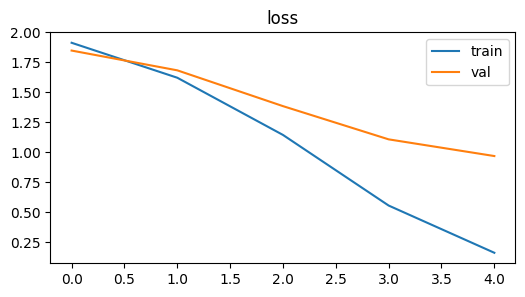

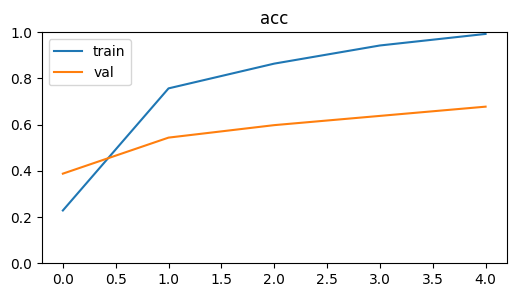

Validation metrics — acc: 0.6780, macro_precision: 0.6945, macro_recall: 0.6737, macro_f1: 0.6839


In [ ]:
num_classes = int(data.y.max().item() + 1)
head = nn.Linear(64, num_classes).to(device)

opt = torch.optim.Adam(
    list(local_encoder.parameters()) +
    list(mamba_layer.parameters()) +
    list(head.parameters()),
    lr=5e-4, weight_decay=5e-4
)
loss_fn = nn.CrossEntropyLoss()
ckpt_path = "graph_mamba_best.pth"
best_val_acc = -1.0
best_epoch = -1
best_state = None

def build_token_batch(node_ids):
    seqs = []
    for v in node_ids:
        token_vectors = []
        for i in reversed(range(1, max_walk_length + 1)):
            token_vectors.append(local_encoder.encode_token(tokens[v][i], data))
        seqs.append(torch.stack(token_vectors, dim=0))
    return torch.stack(seqs, dim=0)

EPOCHS = 5
BATCH = 256
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

for ep in range(EPOCHS):
    local_encoder.train(); mamba_layer.train(); head.train()
    perm = torch.randperm(n, device=device)
    tot_loss = tot_cnt = corr = 0

    for s in range(0, n, BATCH):
        bn = perm[s:s+BATCH]
        bn = bn[data.train_mask[bn]]

        x = build_token_batch(bn.tolist())    # (B, L, 64)
        x = mamba_layer(x)                    # (B, L, 64)
        x = x[:, -1, :]                       # (B, 64)
        y = data.y[bn]

        logits = head(x)
        loss = loss_fn(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        tot_loss += loss.item() * bn.numel()
        tot_cnt  += bn.numel()
        corr     += (logits.argmax(1) == y).sum().item()

    train_loss = tot_loss / max(1, tot_cnt)
    train_acc  = corr / max(1, tot_cnt)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # val
    local_encoder.eval(); mamba_layer.eval(); head.eval()
    with torch.no_grad():
        val_nodes = torch.arange(n, device=device)[data.val_mask].tolist()
        v_loss = v_cnt = v_corr = 0
        for s in range(0, len(val_nodes), BATCH):
            part = val_nodes[s:s+BATCH]
            x = build_token_batch(part)
            x = mamba_layer(x)[:, -1, :]
            y = data.y[part]
            logits = head(x)
            loss = loss_fn(logits, y)
            v_loss += loss.item() * len(part)
            v_cnt  += len(part)
            v_corr += (logits.argmax(1) == y).sum().item()
        val_loss = v_loss / max(1, v_cnt)
        val_acc  = v_corr / max(1, v_cnt)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = ep + 1
        best_state = {
            "epoch": best_epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "local_encoder": local_encoder.state_dict(),
            "mamba_layer": mamba_layer.state_dict(),
            "head": head.state_dict(),
        }

    print(f"epoch {ep+1}: loss={train_loss:.4f} val_loss={val_loss:.4f} | acc={train_acc:.4f} val_acc={val_acc:.4f}")

if best_state is not None:
    torch.save(best_state, ckpt_path)
    local_encoder.load_state_dict(best_state["local_encoder"])
    mamba_layer.load_state_dict(best_state["mamba_layer"])
    head.load_state_dict(best_state["head"])
    print(f"Saved best checkpoint to {ckpt_path} (epoch {best_epoch}, val_acc={best_val_acc:.4f})")
else:
    print("No best checkpoint captured; check your training masks and data pipeline.")

plt.figure(figsize=(6,3))
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist, label="val")
plt.legend()
plt.title("loss")
plt.show()

plt.figure(figsize=(6,3))
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="val")
plt.legend()
plt.title("acc")
plt.ylim(0,1)
plt.show()

local_encoder.eval(); mamba_layer.eval(); head.eval()
val_nodes = torch.arange(n, device=device)[data.val_mask]
all_logits, all_labels = [], []

with torch.no_grad():
    for s in range(0, len(val_nodes), BATCH):
        part = val_nodes[s:s+BATCH]
        x = build_token_batch(part.tolist())
        x = mamba_layer(x)[:, -1, :]
        logits = head(x)
        all_logits.append(logits.cpu())
        all_labels.append(data.y[part].cpu())

if all_logits:
    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)
    preds = logits.argmax(1)

    num_classes = int(labels.max().item() + 1)
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)
    for t, p in zip(labels, preds):
        conf[t, p] += 1

    tp = conf.diag().to(torch.float)
    fp = conf.sum(0).to(torch.float) - tp
    fn = conf.sum(1).to(torch.float) - tp

    macro_prec = (tp / (tp + fp + 1e-8)).mean().item()
    macro_rec  = (tp / (tp + fn + 1e-8)).mean().item()
    macro_f1   = (2 * macro_prec * macro_rec / (macro_prec + macro_rec + 1e-8))
    acc = (preds == labels).float().mean().item()

    print(f"Validation metrics — acc: {acc:.4f}, macro_precision: {macro_prec:.4f}, macro_recall: {macro_rec:.4f}, macro_f1: {macro_f1:.4f}")
else:
    print("No validation samples found to compute metrics.")

### Running

In [ ]:
local_encoder.eval()
mamba_layer.eval()

with torch.no_grad():
    ordered_token_embeddings = []
    for v in range(n):
        vectors = []
        for i in reversed(range(1, max_walk_length + 1)):
            vectors.append(local_encoder.encode_token(tokens[v][i], data))
        
        ordered_token_embeddings.append(torch.stack(vectors, dim=0))

    all_nodes_token_seqs = torch.stack(ordered_token_embeddings, dim=0)
    mixed_token_seqs = mamba_layer(all_nodes_token_seqs)
    node_representations = mixed_token_seqs[:, -1, :]

node_representations

tensor([[ 1.0756,  0.7483,  0.7364,  ..., -0.6473, -1.2911, -2.1195],
        [ 0.8173, -0.0358,  0.0938,  ...,  0.3260,  1.2744, -1.2481],
        [ 1.6225,  0.5150, -0.1238,  ..., -0.4289,  0.2384, -1.3495],
        ...,
        [ 0.6730, -0.0995, -0.2598,  ...,  0.2280,  0.5883, -0.4746],
        [ 0.4007,  0.0123, -1.4991,  ..., -0.8579, -1.6718, -1.7414],
        [ 0.8814,  0.1849, -1.0467,  ..., -0.8568, -2.1247, -2.1235]],
       device='mps:0')

We now have a fixed embedding for every node from the token pipeline. The natural next step is node classification on Cora (predict the topic label for each paper).

In [15]:
# Export predicted labels to cora_visualization_pred.json for the website
label_names = [
    "Case_Based", "Genetic_Algorithms", "Neural_Networks",
    "Probabilistic_Methods", "Reinforcement_Learning",
    "Rule_Learning", "Theory"
]

pred_json_path = "cora_visualization_pred.json"
local_encoder.eval(); mamba_layer.eval(); head.eval()

nodes_pred = []
links_pred = []

# build undirected edge list without duplicates for visualization
seen_edges = set()
edge_pairs = edge_index.t().cpu().tolist()
for s, t in edge_pairs:
    a, b = (int(s), int(t))
    if a > b:
        a, b = b, a
    key = (a, b)
    if key in seen_edges:
        continue
    seen_edges.add(key)
    links_pred.append({"source": a, "target": b})

with torch.no_grad():
    for start in range(0, n, BATCH):
        ids = list(range(start, min(n, start + BATCH)))
        x = build_token_batch(ids)
        x = mamba_layer(x)[:, -1, :]
        logits = head(x)
        pred = logits.argmax(1).cpu().tolist()

        for node_id, cls in zip(ids, pred):
            label_idx = int(cls)
            label_name = label_names[label_idx] if label_idx < len(label_names) else str(label_idx)
            nodes_pred.append({
                "id": int(node_id),
                "label": label_name,
                "labelIdx": label_idx,
                "val": 1.5
            })

with open(pred_json_path, "w", encoding="utf-8") as f:
    json.dump({"nodes": nodes_pred, "links": links_pred}, f)

print(f"Saved predictions to {pred_json_path}: {len(nodes_pred)} nodes, {len(links_pred)} edges")

Saved predictions to cora_visualization_pred.json: 2708 nodes, 5278 edges
